In [183]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])


32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [184]:
char = sorted(list(set(''.join(words))))
stoi = {s :i+1 for i,s in enumerate(char)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


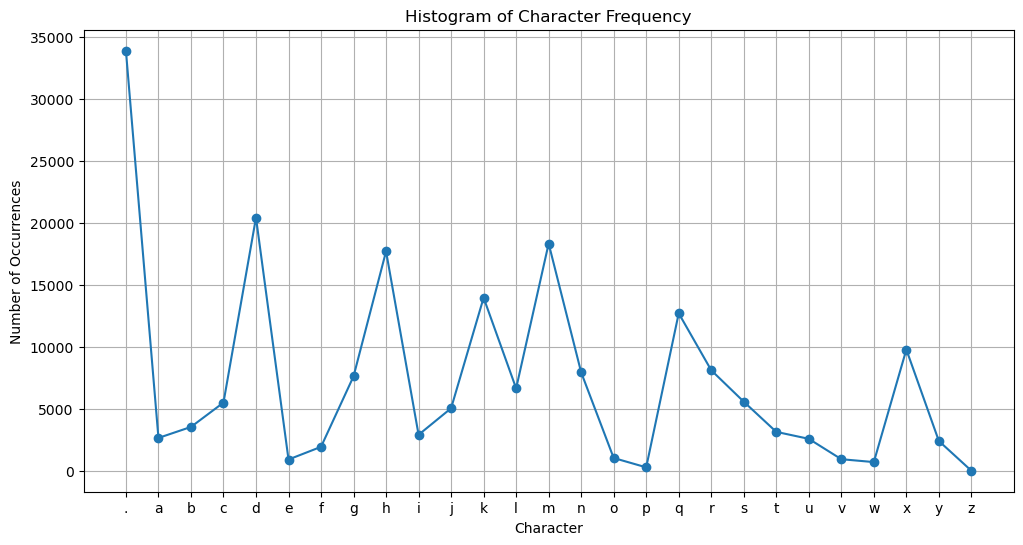

In [185]:
from collections import Counter

char_list = ''.join(words) 
char_counter = Counter(char_list) 

counts = [char_counter.get(s, 0) for s in itos.values()]

plt.figure(figsize=(12, 6))
plt.plot(range(len(counts)), counts, marker='o')
plt.xlabel('Character')
plt.ylabel('Number of Occurrences')
plt.title('Histogram of Character Frequency')
plt.xticks(range(len(counts)), [itos[i] for i in range(len(counts))])  
plt.grid(True)
plt.show()

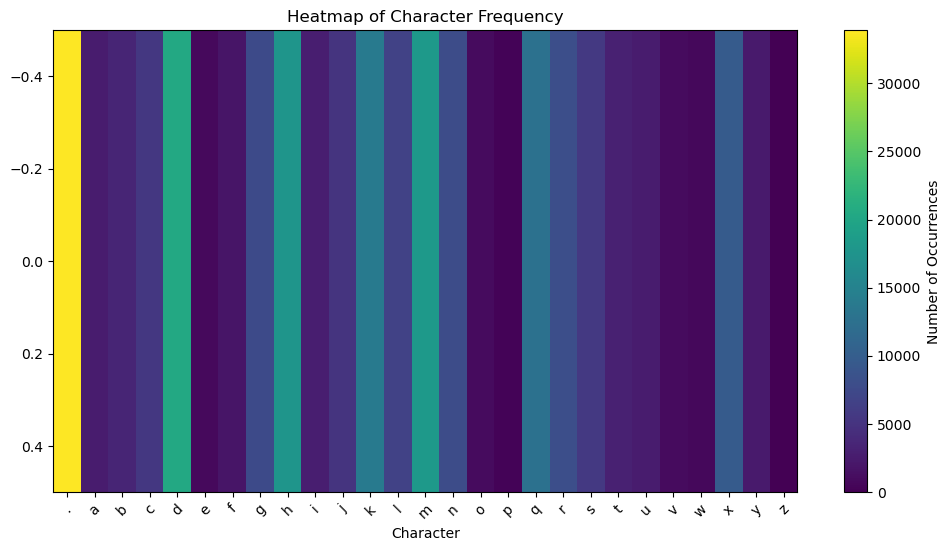

In [186]:
import numpy as np
matrix = np.array(counts).reshape(1, -1) 

plt.figure(figsize=(12, 6))
plt.imshow(matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Number of Occurrences')

plt.xticks(ticks=np.arange(len(itos)), labels=[itos[i] for i in range(len(counts))], rotation=45)

plt.xlabel('Character')
plt.title('Heatmap of Character Frequency')
plt.show()

In [187]:
block_size = 3

def build_dataset(words):
    X,Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int (0.8 * len(words))
n2 = int (0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset (words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


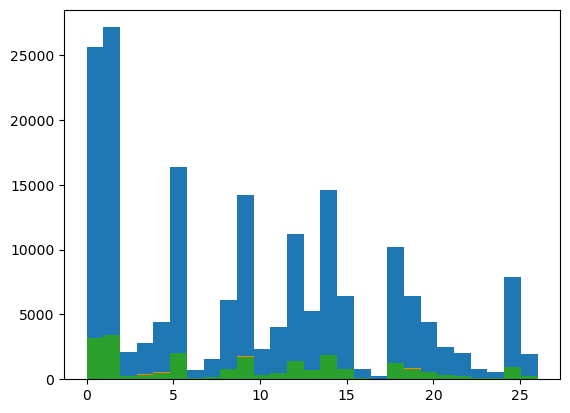

In [188]:
plt.hist(Ytr, bins = vocab_size);
plt.hist(Ydev, bins = vocab_size);  
plt.hist(Yte, bins = vocab_size);


In [189]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [190]:
n_embd = 10 # the dim of the embedding layer
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN

W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters 
for p in parameters:
  p.requires_grad = True

4137


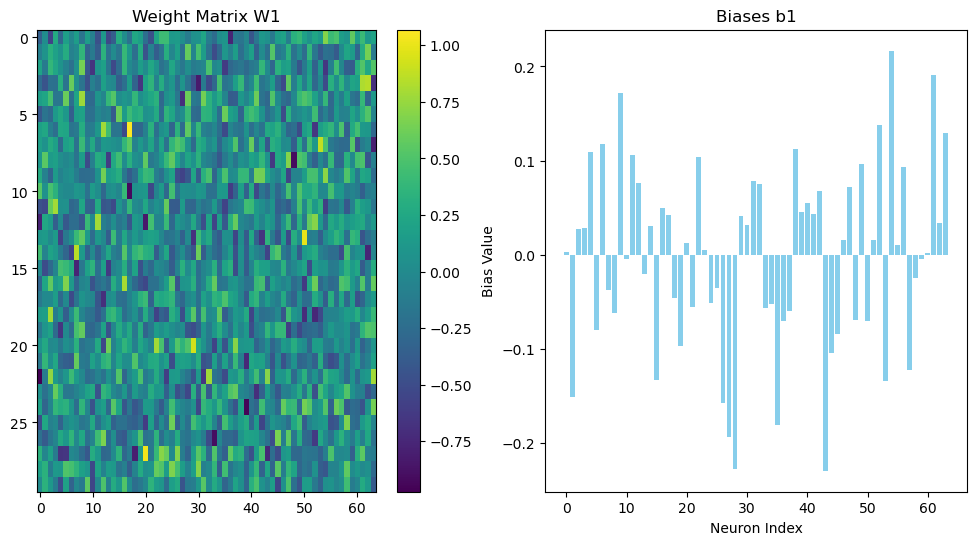

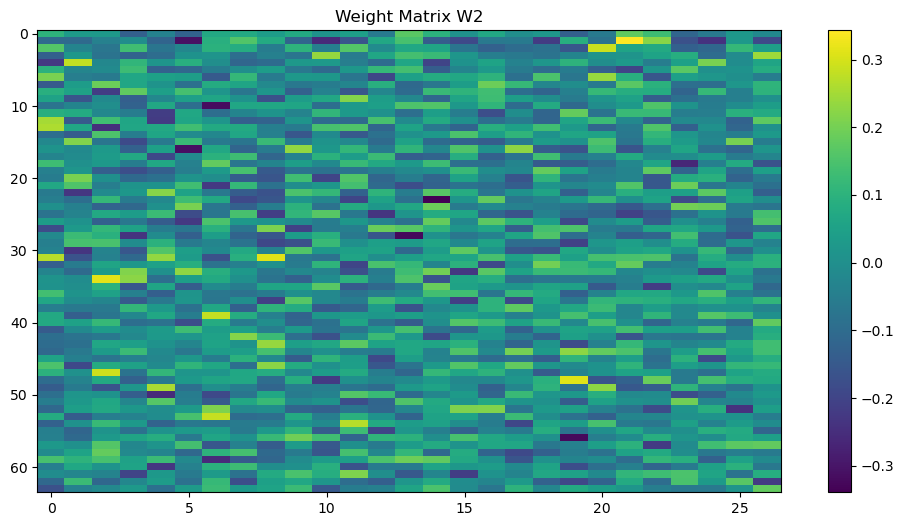

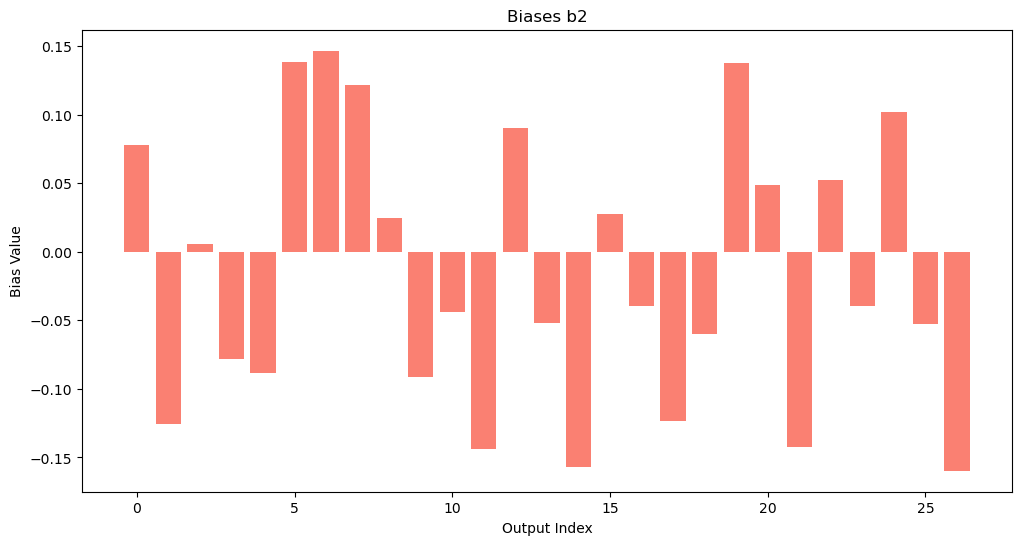

In [191]:
import torch.nn.functional as F
W1_np = W1.detach().numpy()
W2_np = W2.detach().numpy()
b1_np = b1.detach().numpy()
b2_np = b2.detach().numpy()


# Plot Weights W1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(W1_np, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Weight Matrix W1')

# Plot Biases b1
plt.subplot(1, 2, 2)
plt.bar(range(len(b1_np)), b1_np, color='skyblue')
plt.xlabel('Neuron Index')
plt.ylabel('Bias Value')
plt.title('Biases b1')
plt.show()

# Plot Weights W2
plt.figure(figsize=(12, 6))
plt.imshow(W2_np, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Weight Matrix W2')
plt.show()

# Plot Biases b2
plt.figure(figsize=(12, 6))
plt.bar(range(len(b2_np)), b2_np, color='salmon')
plt.xlabel('Output Index')
plt.ylabel('Bias Value')
plt.title('Biases b2')
plt.show()



In [192]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,),  generator = g)
Xb, Yb =  Xtr[ix], Ytr[ix]

In [193]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3486, grad_fn=<NegBackward0>)

In [194]:
counts.shape, counts_sum.shape, counts_sum_inv.shape, probs.shape, logprobs.shape, loss

(torch.Size([32, 27]),
 torch.Size([32, 1]),
 torch.Size([32, 1]),
 torch.Size([32, 27]),
 torch.Size([32, 27]),
 tensor(3.3486, grad_fn=<NegBackward0>))

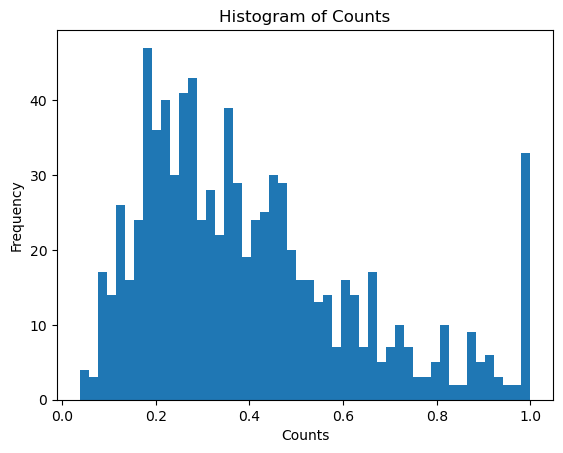

In [195]:
import matplotlib.pyplot as plt

counts_np = counts.detach().numpy()

# Plotting the histogram of the counts tensor
plt.hist(counts_np.flatten(), bins=50)
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Counts')
plt.show();

In [196]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes


dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]
    
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [197]:
bnraw.requires_grad

True

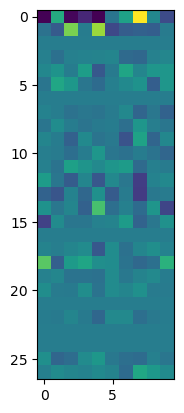

In [198]:
plt.imshow(dC.detach().numpy());

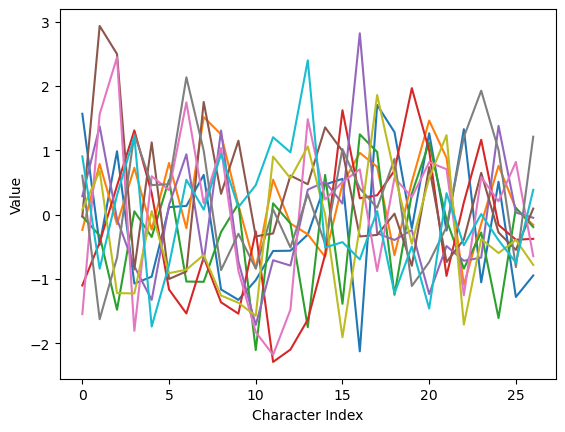

In [199]:
C_np = C.detach().numpy()
plt.plot(C_np)
plt.xlabel('Character Index')
plt.ylabel('Value')

plt.show()

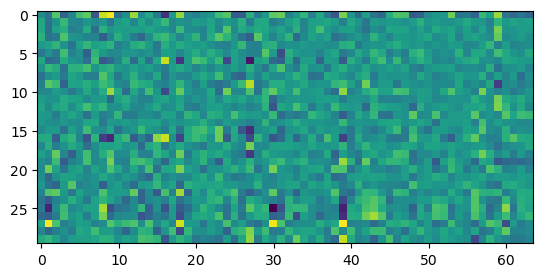

In [200]:
plt.imshow(dW1.detach().numpy());

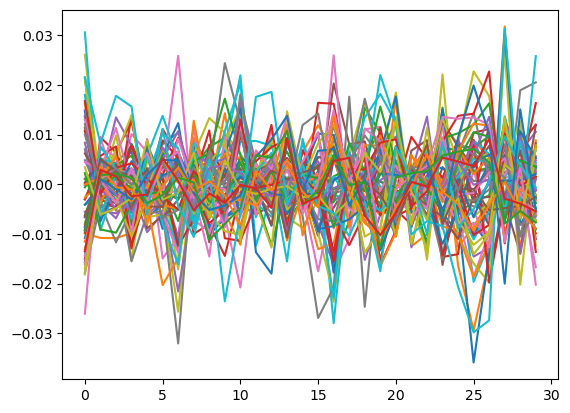

In [201]:
plt.plot(dW1.detach().numpy());

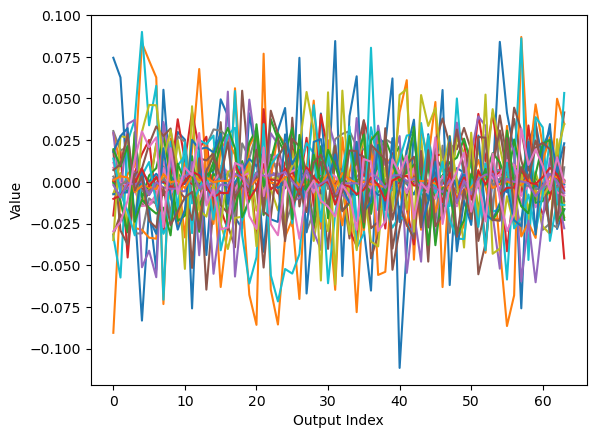

In [202]:
plt.plot(dW2.detach().numpy());
plt.xlabel('Output Index')
plt.ylabel('Value')
plt.show()

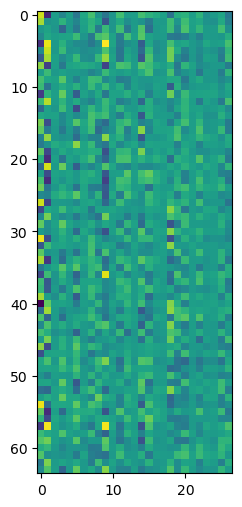

In [203]:
plt.figure(figsize= (18,6))
plt.imshow(dW2.detach().numpy());

In [204]:
loss_fact =  F.cross_entropy(logits, Yb)
print(loss_fact.item(), 'diff:', (loss_fact - loss).item())

3.3486125469207764 diff: 2.384185791015625e-07


In [205]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [206]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [207]:
F.softmax(logits, 1)[0]


tensor([0.0687, 0.0954, 0.0200, 0.0472, 0.0205, 0.0863, 0.0233, 0.0331, 0.0166,
        0.0320, 0.0383, 0.0353, 0.0351, 0.0278, 0.0362, 0.0143, 0.0086, 0.0173,
        0.0167, 0.0527, 0.0479, 0.0230, 0.0231, 0.0732, 0.0625, 0.0260, 0.0192],
       grad_fn=<SelectBackward0>)

In [208]:
dlogits[0] * n

tensor([ 0.0687,  0.0954,  0.0200,  0.0472,  0.0205,  0.0863,  0.0233,  0.0331,
        -0.9834,  0.0320,  0.0383,  0.0353,  0.0351,  0.0278,  0.0362,  0.0143,
         0.0086,  0.0173,  0.0167,  0.0527,  0.0479,  0.0230,  0.0231,  0.0732,
         0.0625,  0.0260,  0.0192], grad_fn=<MulBackward0>)

In [209]:
dlogits[0].sum()

tensor(4.4238e-09, grad_fn=<SumBackward0>)

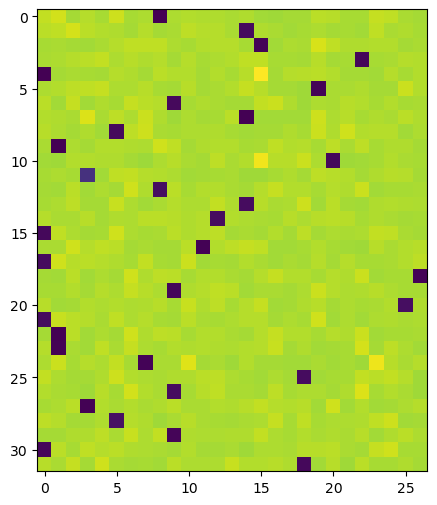

In [210]:
plt.figure(figsize= (18,6))
plt.imshow(dlogits.detach() , cmap='viridis');


In [211]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0)) / (hprebn.std(0, unbiased = True, keepdim = True) + 1e-5) + bnbias  #forward pass
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(1.8358e-05, grad_fn=<MaxBackward1>)


In [212]:
#backward pass
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [213]:
hprebn.shape, hpreact.shape, hpreact_fast.shape,dbnraw.shape, dbnvar.shape, bnraw.shape, bnvar_inv.shape, hpreact_fast.requires_grad


(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 True)

In [214]:


n_embd = 10 # the dim of the embedding layer
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                      generator=g) * 0.1 

W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.1
b2 = torch.randn(vocab_size,                   generator=g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0 
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
    
#optimization

max_epochs = 20000
batch_size = 32
n = batch_size
lossi = []


with torch.no_grad():
    
    for i in range(max_epochs):
        
        ix = torch.randint(0, Xtr.shape[0],(batch_size,) , generator = g)
        
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        
        emb = C[Xb]
        emncat = emb.view(emb.shape[0], -1)
        
        hprebn = embcat @ W1 + b1
        
        bnmean = hprebn.mean(0, keepdim = True)
        bnvar = hprebn.var (0, keepdim = True, unbiased = True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias


        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        
        loss = F.cross_entropy(logits, Yb)
        
        for p in parameters:
            p.grad = None

        # loss.backward()
        
        dlogits = F.softmax(logits, dim = 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        
        db2 = dlogits.sum(0)
        
        dhpreact = (1.0 - h**2)  * dh

        dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
        dbnbias = dhpreact.sum(0, keepdim = True)
        dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))
        
        dembcat = dhprebn @ W1.T
        dW1 = dembcat.T @ dhprebn 
        db1 = dhprebn.sum(0)
        
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)    
        
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
                
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        
        lr = 0.5 if i < 100000 else 0.01
    
        for p,grad in zip(parameters, grads):
            p.data = -lr * grad

        if i % 10000 == 0:  
            print(f'{i: 7d}/ {max_epochs: 7d} | Loss: {loss.item():.4f}')
        lossi.append(loss.log10(). item())


12297
      0/   20000 | Loss: 3.6342
  10000/   20000 | Loss: 3.2741


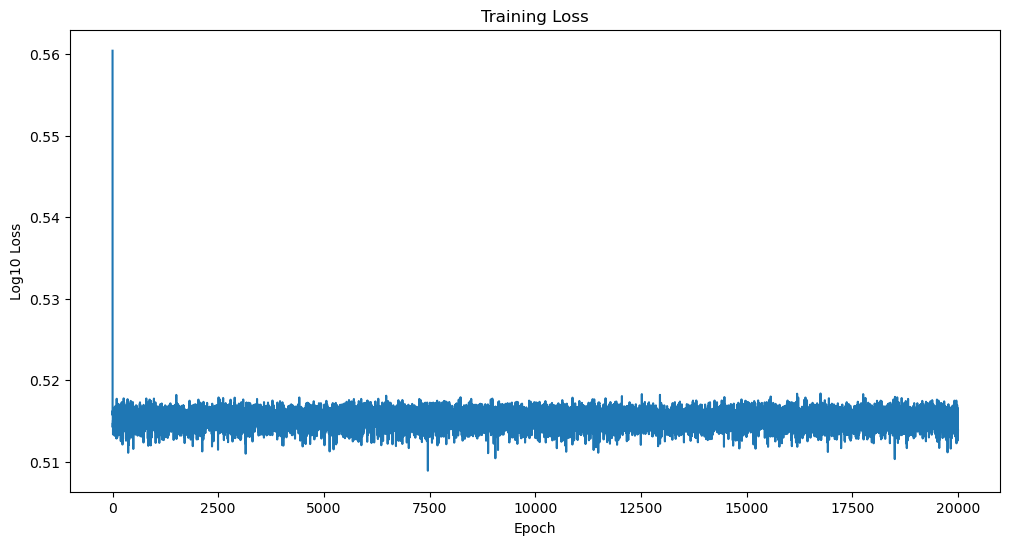

In [215]:
plt.figure(figsize=(12, 6))
plt.xlabel('Epoch')
plt.ylabel('Log10 Loss')
plt.title('Training Loss')

plt.plot(lossi);

In [216]:
with torch.no_grad():
    emb = C[Xtr]
    
    embcat = emb.view(emb.shape[0], -1)
    
    hpreact = embcat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim = True)
    
    bnvar = hpreact.var(0, keepdim = True, unbiased = True)
    

In [217]:
@torch.no_grad()

def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy (logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')


train 3.267150640487671
val 3.2671258449554443


In [218]:
loss

tensor(3.2649)

In [219]:
b1.shape, b2.shape, W1.shape, W2.shape

(torch.Size([200]),
 torch.Size([27]),
 torch.Size([30, 200]),
 torch.Size([200, 27]))

In [220]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

erbuagmyazzhzevvndhfyaloqetvrsjejdrlrg.
ozcjedgeliihsmpqppalekeixvqnwxarqeptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjkjqqxntpucfkubzmgvdtrxyqqufzehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxrfqnxoeobhggptixjsfcueywhkhmreolbiilqiif.
wvpkxwvlla.
ortabfsztjndgoikvsblitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudt.
iwbddihzvorlq.
cjakepxugniagcrpppfmiipzjgvonxet.
jydnblkskzporygnogsvmwosfzybsyknvmjcxtkncjbmu.
jtew.
aow.
copmrlxkzdcqbcep.
ccafivsnipimhtecmokagouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxzhosy.
sj.
ascnpc.
cilwtanczhndtebimm.


In [221]:
embcat.shape, W1.shape, b1.shape

(torch.Size([1, 30]), torch.Size([30, 200]), torch.Size([200]))